## AML Package for Text Analytics - Text Classification 
### Text Classification using Convolutional Neural Networks (CNNs) and Word2Vec Embeddings

### Background

Sentiment analysis is the task of extracting the intended subjective information conveyed by a text. It's most common form is for polarity extraction, i.e., distinguishing between positive and negative attitudes toward some item or product.

One major difficulty is that the judgment of the polarity of an opinion can be subjective. Humans, for instance, usually disagree when judging the sentiment of a sentence, typically reaching only modest inter‐annotator agreement.

Moreover, polarity has to be interpreted within a context (contextual polarity). Thus, the polarity of a word can be modified in a sentence due to linguistic phenomena such as negation, modality, intensifiers, diminishers, and word sense.

Deep learning is an emergent area of machine learning that offers methods for learning feature representation in a supervised or unsupervised fashion within a hierarchy. Typically, high layers of the hierarchy will have a more abstract representation (i.e., distributed representation) than lower layers. Higher layers evolve during training to exploit complex compositional nonlinear functions of the lower layers.

We apply deep learning architectures to the task of sentiment analysis on a corpus of [polarized movie reviews](http://ai.stanford.edu/~amaas/data/sentiment/) from the IMDB website. This dataset was curated by Andrew Maas and fellow researchers at Stanford University, and is sometimes referred to as the _large movie review dataset_. We've provided a helper function to download the raw dataset from the URL, and transform it into a pandas DataFrame. 


### Convolutions for Text
In this tutorial we showcase the use of neural networks with convolutions and pooling operations. The main idea behind a convolution and pooling architecture for language tasks is to apply a nonlinear (learned) function over each instantiation of a $k$-word sliding window over the sentence. For our use-case, we use a 1D convolution + maximum pooling over the review using a pre-trained word-embedding matrix.

This architecture looks up each word in the embedding matrix to obtain an embedding vector, and a "window" of embedding vectors are concatenated together prior to the application of non-linearity and a maximum pooling operation to create features to use as predictors of sentiment. A pictorial representation of this operation over a sample sentence is given below (image is from _Yoav Goldberg (2017) - Neural Networks for Natural Language Processing, Morgan & Claypool Publishers_)

![Yoav Goldberg - Neural Networks for Natural Language Processing](img/conv-pool-text.png)

Following are the steps for creating and deploying a custom entity extraction model using the package:
<br> Step 1: Loading dataset and pre-trained embedding model
<br> Step 2: Model training
<br> Step 3: Apply the custom entity extractor 
<br> Step 4: Performance Evaluation
<br> Step 5: Save the pipeline 
<br> Step 6: Load the pipeline 
<br> Step 7: Run the pipeline on unlabeled data
<br> Step 8: Operationalize - Deploy the pipeline

## Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import sys
!{sys.executable} -m pip show azureml-tatk

Name: azureml-tatk
Version: 0.1.18123.2b3
Summary: Microsoft Azure Machine Learning Package for Text Analytics
Home-page: https://microsoft.sharepoint.com/teams/TextAnalyticsPackagePreview
Author: Microsoft Corporation
Author-email: amltap@microsoft.com
License: UNKNOWN
Location: /anaconda/envs/aztatkmlads/lib/python3.5/site-packages
Requires: validators, h5py, nltk, jsonpickle, pytest, pdfminer.six, pyspark, dill, ruamel.yaml, matplotlib, nose, bqplot, azure-ml-api-sdk, ipython, scipy, qgrid, numpy, docker, lxml, sklearn-crfsuite, keras, scikit-learn, ipywidgets, unidecode, pandas, azure-storage, gensim, requests
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [4]:
import numpy as np
import pandas as pd
import os
import pathlib
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import keras

Using TensorFlow backend.


## Step 1: Loading dataset and pre-trained embedding model

We need to download the movie review dataset as well as the embedding model we will use in our network. Please download the data from [IMDB Data](ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz) and save it to your home directory under `tatk\resources\data\imdb`.

In [5]:
resources_dir = os.path.join(os.path.expanduser("~"), "tatk", "resources")
data_dir = os.path.join(resources_dir, "data")

def load_imdb_data(data_dir:str=data_dir, out_numpy:bool=True):
    
    """Load IMDB Dataset into numpy or pandas dataframe

    Returns movies DataFrame of reviews. For more information about the dataset, please see the original source:
    [Andrew Maas, Large Movie Review Dataset](http://ai.stanford.edu/~amaas/data/sentiment/). 
    Andrew L. Maas, Raymond E. Daly, Peter T. Pham, Dan Huang, Andrew Y. Ng, and Christopher Potts. (2011). 
        Learning Word Vectors for Sentiment Analysis. The 49th Annual Meeting of the Association for Computational Linguistics (ACL 2011).

    
    data_dir : str, optional
        Path to save data (the default is data_dir, which is `tatk.utils.load_data.data_dir`)
    out_numpy : bool, optional
        Whether to return numpy or Pandas (the default is True, which returns a tuple of length four of numpy arrays)
    
    Returns
    -------
    Numpy or Pandas data of reviews
    """
    
    def reporthook(count, block_size, total_size):
        global start_time
        if count == 0:
            start_time = time.time()
            return
        duration = time.time() - start_time
        progress_size = int(count * block_size)
        speed = progress_size / (1024.**2 * duration)
        percent = count * block_size * 100. / total_size
        sys.stdout.write("\r%d%% | %d MB | %.2f MB/s | %d sec elapsed" %
                        (percent, progress_size / (1024.**2), speed, duration))
        sys.stdout.flush()
        
    import sys
    import time
    import tarfile
    import pandas as pd
    import pathlib

    tar_file = pathlib.Path(data_dir) / "imdb" / "aclImdb_v1.tar.gz"  
    tar_file = str(tar_file)
    target_dir = pathlib.Path(data_dir) / "imdb"
    target_dir = str(target_dir)

    print(50 * '-')
    print("Loading from disk if available, otherwise extract and load downloaded tar")

    csv_path = pathlib.Path(data_dir) / "imdb" / "reviews.csv"  
    if not csv_path.parent.exists():
        csv_path.parent.mkdir(parents=True)

    if os.path.isfile(str(csv_path)):
        print(50 * "-")
        print("Loading saved CSV from disk")
        df = pd.read_csv(str(csv_path))
    else:
        if not os.path.isdir(os.path.join(target_dir, "aclImdb")) and not os.path.isfile(tar_file):
            print(50 * '=')
            print('Data has not yet been downloaded, please download from http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz')
            return
        if not os.path.isdir(os.path.join(target_dir, "aclImdb")):
            print(50 * '=')
            print("Extracting tarfile")
            with tarfile.open(tar_file, 'r:gz') as tar:
                tar.extractall(path = target_dir)
                
        print(50 * "-")
        print("CSV not found, loading from source, this might take a few minutes")
        labels = {'pos': 1, 'neg': 0}
        df = pd.DataFrame()
        for s in ('train', 'test'):
            for l in ('pos', 'neg'):
                path = os.path.join(target_dir, "aclImdb", s, l)
                for file in os.listdir(path):
                    with open(os.path.join(path, file), 'r',
                              encoding='utf-8') as infile:
                        txt = infile.read()
                    df = df.append([[txt, labels[l]]], ignore_index=True)
        df.columns = ['review', 'sentiment']
        df.to_csv(str(csv_path), index=False)

    X_train = df.loc[0:24999, "review"]
    y_train = df.loc[0:24999, 'sentiment']
    X_test = df.loc[25000:, "review"]
    y_test = df.loc[25000:, 'sentiment']


    if out_numpy:
        print("Returning numpy arrays, X_train, y_train, X_test, y_test")
        return X_train, y_train, X_test, y_test
    else:
        print("Returning Pandas DataFrame")
        return df

In [6]:
X_train, y_train, X_test, y_test = load_imdb_data(data_dir=str(data_dir))

--------------------------------------------------
Loading from disk if available, otherwise extract and load downloaded tar
--------------------------------------------------
Loading saved CSV from disk
Returning numpy arrays, X_train, y_train, X_test, y_test


### Download the Embedding Model

Download pretrained Google word embedding model [GoogleNews-vectors-negative300.bin.gz](https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download), and save it your home directory under `tatk\resources\models\Word2Vec_Models\`.

In [7]:
import pathlib
embedding_file_path = str(pathlib.Path(resources_dir).joinpath("models", "Word2Vec_Models", 
                                                               "GoogleNews-vectors-negative300.bin"))

In [8]:
imdb_train = pd.DataFrame({'review': X_train, 'sentiment': y_train})
imdb_train[0:5]

,review,sentiment
0,What can you say when you see a good French mo...,1
1,There have been countless talking-animal films...,1
2,"""Spin it!""<br /><br />The 90s opened up with a...",1
3,Wonderland is the fascinating film chronicling...,1
4,Sniper gives a true new meaning to war movies....,1


In [9]:
imdb_train['word_counts'] = imdb_train['review'].str.split().apply(len)

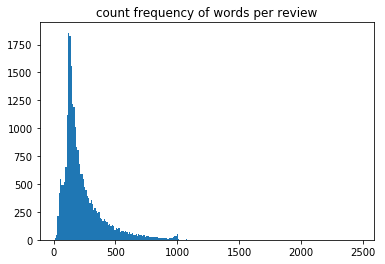

In [10]:
plt.hist(imdb_train['word_counts'], bins = "auto")
plt.title("count frequency of words per review")
plt.show()

In [11]:
print("average unique tokens in a review: ", imdb_train['word_counts'].mean())

average unique tokens in a review:  233.7872


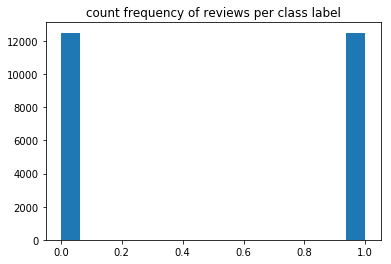

In [12]:
plt.hist(imdb_train['sentiment'], bins = "auto")
plt.title("count frequency of reviews per class label")
plt.show()

There is a large right tail to the length of review, meaning some reviewers are very verbose (over 2000 unique words in one review!), while others are very curt. The minimum length is four unique words:

In [13]:
print(imdb_train[imdb_train["review"].apply(lambda x: len(str.split(x)) == imdb_train['word_counts'].min())]["review"].values)

['This movie is terrible but it has some good effects.'
 "I wouldn't rent this one even on dollar rental night."]


In [14]:
print(imdb_train[imdb_train["review"].apply(lambda x: len(str.split(x)) == imdb_train['word_counts'].max())]["review"].values)

['Match 1: Tag Team Table Match Bubba Ray and Spike Dudley vs Eddie Guerrero and Chris Benoit Bubba Ray and Spike Dudley started things off with a Tag Team Table Match against Eddie Guerrero and Chris Benoit. According to the rules of the match, both opponents have to go through tables in order to get the win. Benoit and Guerrero heated up early on by taking turns hammering first Spike and then Bubba Ray. A German suplex by Benoit to Bubba took the wind out of the Dudley brother. Spike tried to help his brother, but the referee restrained him while Benoit and Guerrero ganged up on him in the corner. With Benoit stomping away on Bubba, Guerrero set up a table outside. Spike dashed into the ring and somersaulted over the top rope onto Guerrero on the outside! After recovering and taking care of Spike, Guerrero slipped a table into the ring and helped the Wolverine set it up. The tandem then set up for a double superplex from the middle rope which would have put Bubba through the table, b

## Step 2: Model training

In [15]:
from tatk.pipelines.text_classification.keras_embedding_text_classifier import KerasEmbeddingTextClassifier
import datetime
log_dir = pathlib.Path(resources_dir) / "logs"
imdb_logs = str(log_dir / "imdb_results" / datetime.datetime.now().strftime("%Y_%m_%d") / "kernel_3")

# the generic word embedding model has 3M words. We load the top <max_features> words as input features to the neural network
max_features=100000

keras_text_classifier = KerasEmbeddingTextClassifier(embedding_file_path, 
                                                     input_col="review", 
                                                     label_cols="sentiment",
                                                     model_type="CNN",
                                                     binary_format=True, 
                                                     limit=max_features,
                                                     cuda_devices="0",
                                                     callbacks=True,
                                                     log_dir=imdb_logs)

KerasEmbeddingTextClassifier::create_pipeline ==> start
Word2VecVectorizer::load_embeddings ==> start
Time taken: 0.07 mins
Word2VecVectorizer::load_embeddings ==> end
num_words=100002
:: number of jobs for the pipeline : 24
0	nltk_preprocessor
1	vectorizer
2	learner
KerasEmbeddingTextClassifier::create_pipeline ==> end


### View and Modify Pipeline and Model Parameters

Since we are using a slice of the full word embedding matrix (i.e., specified by the `limit` parameter and `max_features` value above) it'll be more efficient to not save the entire word-embedding matrix in our saved pipeline. This can be specified by modifying the `get_from_path` argument in the word2vec `vectorizer`. 

In [16]:
keras_text_classifier.get_params()

{'binary_format': True,
 'callbacks': True,
 'class_type': 'single-label',
 'cuda_devices': '0',
 'embedding_file_path': '/home/alizaidi/tatk/resources/models/Word2Vec_Models/GoogleNews-vectors-negative300.bin',
 'input_col': 'review',
 'label_cols': ['sentiment'],
 'limit': 100000,
 'log_dir': '/home/alizaidi/tatk/resources/logs/imdb_results/2018_06_12/kernel_3',
 'model_type': 'CNN',
 'n_labels': None,
 'regex': None,
 'trainable_embedding': False}

In [17]:
keras_text_classifier.get_step_params_by_name("learner")

{'batch_size': 50,
 'callbacks_list': ['tensorboard', 'checkpoint', 'early'],
 'cuda_devices': '0',
 'feature_cols': ['features'],
 'input_padding_value': 100001,
 'label_cols': ['sentiment'],
 'log_path': '/home/alizaidi/tatk/resources/logs/imdb_results/2018_06_12/kernel_3',
 'max_len': None,
 'model__class_type': 'single-label',
 'model__dropout_rate': 0.25,
 'model__hidden_dims': 250,
 'model__init_wordvecs': array([[ 1.12915039e-03, -8.96453857e-04,  3.18527222e-04, ...,
         -1.56402588e-03, -1.23023987e-04, -8.63075256e-05],
        [ 7.03125000e-02,  8.69140625e-02,  8.78906250e-02, ...,
         -4.76074219e-02,  1.44653320e-02, -6.25000000e-02],
        [-1.17797852e-02, -4.73632812e-02,  4.46777344e-02, ...,
          7.12890625e-02, -3.49121094e-02,  2.41699219e-02],
        ...,
        [ 5.03540039e-03, -9.57031250e-02,  1.75781250e-01, ...,
          1.84570312e-01, -2.13867188e-01,  2.63671875e-01],
        [-8.07216235e-02, -4.79336421e-03, -5.50363425e-02, ...,
   

In [18]:
keras_text_classifier.set_step_params_by_name("learner", model__kernel_size=[3])
keras_text_classifier.set_step_params_by_name("vectorizer", get_from_path=False)

In [19]:
keras_text_classifier.fit(imdb_train)

KerasEmbeddingTextClassifier::fit ==> start
schema: col=review:TX:0 col=sentiment:I8:1 col=word_counts:I8:2 header+
NltkPreprocessor::tatk_fit_transform ==> start
NltkPreprocessor::tatk_fit_transform ==> end 	 Time taken: 0.11 mins
Word2VecVectorizer::tatk_fit_transform ==> start
Word2VecVectorizer::tatk_fit_transform ==> end 	 Time taken: 0.1 mins
KerasEmbeddingTextClassifierLearner::tatk_fit ==> start
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 300)         30000600  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 250)         225250    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 250)               0         

KerasEmbeddingTextClassifier(binary_format=True, callbacks=True,
               class_type='single-label', cuda_devices='0',
               embedding_file_path='/home/alizaidi/tatk/resources/models/Word2Vec_Models/GoogleNews-vectors-negative300.bin',
               input_col='review', label_cols=['sentiment'], limit=100000,
               log_dir='/home/alizaidi/tatk/resources/logs/imdb_results/2018_06_12/kernel_3',
               model_type='CNN', n_labels=None, regex=None,
               trainable_embedding=False)

## Step 3: Apply the text classifier

In [23]:
imdb_test = pd.DataFrame({'review': X_test, 'sentiment': y_test})
keras_text_classifier.predict(imdb_test)
imdb_test[-5:]

KerasEmbeddingTextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.11 mins
Word2VecVectorizer::tatk_transform ==> start
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.09 mins
KerasEmbeddingTextClassifierLearner::tatk_predict_proba ==> start
KerasEmbeddingTextClassifierLearner::tatk_predict_proba ==> end 	 Time taken: 0.13 mins
KerasEmbeddingTextClassifierLearner::tatk_predict ==> start
KerasEmbeddingTextClassifierLearner::tatk_predict ==> end 	 Time taken: 0.13 mins
Time taken: 0.46 mins
KerasEmbeddingTextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object


,review,sentiment,probabilities,prediction
49995,Wow! That James Purefoy looks exactly like Tho...,0,"[0.999469, 0.00053104106]",0
49996,"Right... so you have a dam, tons of water (tha...",0,"[0.9958845, 0.004115557]",0
49997,This film is one of the worst adaptations of P...,0,"[0.99001104, 0.009989011]",0
49998,European films may be slower-paced and less pl...,0,"[0.98406756, 0.015932493]",0
49999,I saw this movie on the shelf at Blockbuster a...,0,"[0.99453, 0.0054699695]",0


## Step 4: Performance evaluation

In [24]:
res = keras_text_classifier.evaluate(imdb_test)

KerasEmbeddingTextClassifier ::evaluate ==> start
Time taken: 0.0 mins
KerasEmbeddingTextClassifier ::evaluate ==> end


Confusion matrix, without normalization
[[11427  1073]
 [ 1821 10679]]


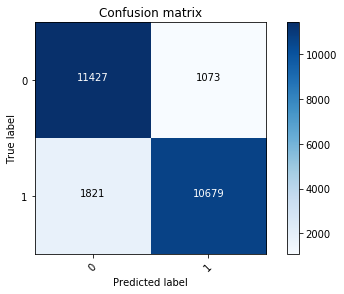

In [25]:
res.plot_confusion_matrix()

Normalized confusion matrix
[[0.91416 0.08584]
 [0.14568 0.85432]]


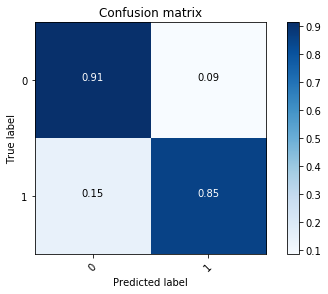

In [26]:
res.plot_confusion_matrix(normalize=True)

## Step 5: Save the pipeline 

Create a path to save your pipeline and model:

In [27]:
pipeline_path = pathlib.Path(resources_dir) / "models" / datetime.datetime.now().strftime("%Y_%m_%d") / "keras_text_classifier_cnn"
if not pipeline_path.exists(): pipeline_path.mkdir(parents=True)
print(pipeline_path)

/home/alizaidi/tatk/resources/models/2018_06_12/keras_text_classifier_cnn


In [28]:
keras_text_classifier.save(str(pipeline_path))

BaseTextModel::save ==> start
TatkPipeline::save ==> start
Time taken: 0.29 mins
TatkPipeline::save ==> end
Time taken: 0.29 mins
BaseTextModel::save ==> end


## Step 6: Load the pipeline

In [29]:
loaded_keras_model = keras_text_classifier.load(str(pipeline_path))

BaseTextModel::load ==> start
TatkPipeline::load ==> start
Word2VecVectorizer: Word2Vec model loaded from /home/alizaidi/tatk/resources/models/2018_06_12/keras_text_classifier_cnn/pipeline/vectorizer/embedding_table.txt
Time taken: 0.43 mins
TatkPipeline::load ==> end
Time taken: 0.43 mins
BaseTextModel::load ==> end


KerasEmbeddingTextClassifier ::evaluate ==> start
Time taken: 0.0 mins
KerasEmbeddingTextClassifier ::evaluate ==> end
Normalized confusion matrix
[[0.91416 0.08584]
 [0.14568 0.85432]]


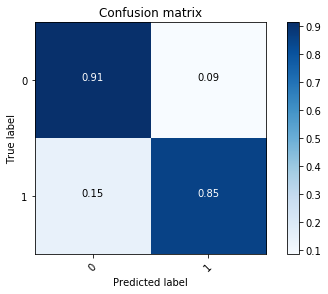

In [30]:
verify_res = loaded_keras_model.evaluate(imdb_test)
verify_res.plot_confusion_matrix(normalize="True")

### Verify the same as before:

In [31]:
(res.cnf_matrix == verify_res.cnf_matrix).all()

True

## Predictions

### You can evaluate on new data. Let's try a hard example:

In [32]:
df_predict = pd.DataFrame({'review' : ["This movie was so bad it was awesome"]})
df_res = loaded_keras_model.predict(df_predict)
df_res

KerasEmbeddingTextClassifier ::predict ==> start
NltkPreprocessor::tatk_transform ==> start
NltkPreprocessor::tatk_transform ==> end 	 Time taken: 0.0 mins
Word2VecVectorizer::tatk_transform ==> start
Word2VecVectorizer::tatk_transform ==> end 	 Time taken: 0.0 mins
KerasEmbeddingTextClassifierLearner::tatk_predict_proba ==> start
KerasEmbeddingTextClassifierLearner::tatk_predict_proba ==> end 	 Time taken: 0.0 mins
KerasEmbeddingTextClassifierLearner::tatk_predict ==> start
KerasEmbeddingTextClassifierLearner::tatk_predict ==> end 	 Time taken: 0.0 mins
Time taken: 0.0 mins
KerasEmbeddingTextClassifier ::predict ==> end
Order of Labels in predicted probabilities saved to attribute label_order of the class object


,review,probabilities,prediction
0,This movie was so bad it was awesome,"[0.9084107, 0.0915893]",0
